In [100]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import datetime,time
from datetime import datetime,timedelta
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBRegressor
import optuna

# Chargement des données

In [46]:
def Load_Turb(path):
    return pd.read_csv(path ,sep=';',decimal=',',parse_dates=['DateTime'],dayfirst=True)

csv_path = ['./FRSSO18.csv','./FRMHN11.csv','./FRBRE_E03.csv','./FRHVA_E04.csv','./FRMHN_E06.csv']
Turbs_Raw = [Load_Turb(p) for p in csv_path]         
Turbs = ['Turb1','Turb2','Turb3','Turb4','Turb5']

# Augmentation features

In [41]:
def Augmentation_Features(df):
    df['Year'] = pd.to_datetime(df['DateTime']).dt.year
    df['Month'] = pd.to_datetime(df['DateTime']).dt.month
    df['Day'] = pd.to_datetime(df['DateTime']).dt.day
    df['Hour'] = pd.to_datetime(df['DateTime']).dt.hour
    df['N1'] = (2 * df['ProductionForecast_M'] + df['ProductionForecast_D']) / 3
    df['N2'] = (df['ProductionForecast_M'])**(2/3) * (df['ProductionForecast_D'])**(1/3)
    df['D<M'] = df['ProductionForecast_M'] > df['ProductionForecast_D']
    df['D*M'] = df['ProductionForecast_D'] * df['ProductionForecast_M']
    df['D-M2'] = df['ProductionForecast_D']  - df['ProductionForecast_M']**2 
    df['D2-M'] = df['ProductionForecast_D']**2  - df['ProductionForecast_M']
    return df

In [43]:
Turbs_df = [Augmentation_Features(df) for df in Turbs_Raw]   

In [45]:
Turbs_df[0]

,DateTime,ActivePower,ProductionForecast_D,ProductionForecast_M,Year,Month,Day,Hour,N1,N2,D<M,D*M,D-M2,D2-M
0,2020-03-05 00:00:00,1614.345422,948.189357,745.2,2020,3,5,0,812.863119,807.508166,False,706590.708836,-554374.850643,8.983179e+05
1,2020-03-05 01:00:00,1478.355419,967.269962,711.8,2020,3,5,1,796.956654,788.414415,False,688502.758952,-505691.970038,9.348994e+05
2,2020-03-05 02:00:00,1690.147069,948.830677,645.0,2020,3,5,2,746.276892,733.560688,False,611995.786665,-415076.169323,8.996347e+05
3,2020-03-05 03:00:00,1516.965994,1102.870568,645.0,2020,3,5,3,797.623523,771.284598,False,711351.516360,-414922.129432,1.215678e+06
4,2020-03-05 04:00:00,936.617865,962.811666,568.8,2020,3,5,4,700.137222,677.881070,False,547647.275621,-322570.628334,9.264375e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11673,2021-10-16 14:00:00,0.423586,0.000000,0.0,2021,10,16,14,0.000000,0.000000,False,0.000000,0.000000,0.000000e+00
11674,2021-10-16 16:00:00,33.743984,0.000000,0.0,2021,10,16,16,0.000000,0.000000,False,0.000000,0.000000,0.000000e+00
11675,2021-10-16 17:00:00,66.180937,29.035056,0.0,2021,10,16,17,9.678352,0.000000,False,0.000000,29.035056,8.430345e+02
11676,2021-10-16 22:00:00,3.609505,0.000000,4.0,2021,10,16,22,2.666667,0.000000,True,0.000000,-16.000000,-4.000000e+00


## Préparation train et test

In [74]:
# Si on veut un an de train et le reste de test, quel est l'indice de split dans le dataset? 
def traindf(df):
    return df.loc[((df['DateTime']>= datetime(2020,3,5,0,0,0)) &  (df['DateTime']<= datetime(2021,3,4,23,0,0)))]

def testdf(df):
    return df.loc[((df['DateTime']>= datetime(2021,3,5,0,0,0)) &  (df['DateTime']<= datetime(2021,10,17,23,1,0,0)))]


def rmse_mae_ref(df):
       
       ref_test_D = df.loc[((df['DateTime']>= datetime(2021,3,5,0,0,0)) &  (df['DateTime']<= datetime(2021,10,17,23,1,0,0))),['ProductionForecast_D']]
       ref_test_M = df.loc[((df['DateTime']>= datetime(2021,3,5,0,0,0)) &  (df['DateTime']<= datetime(2021,10,17,23,1,0,0))),['ProductionForecast_M']]
       ref_test_TruePower = df.loc[((df['DateTime']>= datetime(2021,3,5,0,0,0)) &  (df['DateTime']<= datetime(2021,10,17,23,1,0,0))),['ActivePower']]
       
       rmse_D = mean_squared_error(ref_test_TruePower, ref_test_D,squared=False)
       mae_D = mean_absolute_error(ref_test_TruePower, ref_test_D)
       rmse_M = mean_squared_error(ref_test_TruePower, ref_test_M,squared=False)
       mae_M = mean_absolute_error(ref_test_TruePower, ref_test_M)
       return {'ProductionForcast_D': (rmse_D,mae_D), 'ProductionForcast_M': (rmse_M,mae_M)}




In [48]:
Turbs_train = [traindf(df_t) for df_t in Turbs_df]
Turbs_test = [testdf(df_t) for df_t in Turbs_df]
                                                                        

# Régression linéaire

In [57]:
def Lreg(df_Train, df_Test):
    
    Lreg_LR = LinearRegression().fit(df_Train[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']], df_Train['ActivePower'])
    y_pred = Lreg_LR.predict(df_Test[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']])    

    rmse_lreg = mean_squared_error(df_Test['ActivePower'], y_pred,squared=False)
    mae_lreg = mean_absolute_error(df_Test['ActivePower'], y_pred)
    return rmse_lreg,mae_lreg

#print('rmse_lreg1 : {}'.format(rmse_lreg1))
#print('mae_lreg1 : {}'.format(mae_lreg1))

In [58]:
Score = [Lreg(df_Train,df_Test)  for df_Train,df_Test in zip(Turbs_train,Turbs_test)]

In [77]:
def affiche_Score(Score):
    for i,tup in enumerate(Score):
        print (Turbs[i])
        print ('rmse = ',tup[0])
        print ('mae = ',tup[1])
affiche_Score(Score)

Turb1
rmse =  283.2967027613794
mae =  202.42841128285903
Turb2
rmse =  424.2955710239643
mae =  302.5368576739603
Turb3
rmse =  206.19467715473158
mae =  146.41301662629758
Turb4
rmse =  182.5599825223806
mae =  129.33112200380637
Turb5
rmse =  472.9926425806527
mae =  339.40685387227836


In [75]:
reference = [rmse_mae_ref(df) for df in Turbs_df]

In [76]:
reference

[{'ProductionForcast_D': (330.47829663202106, 219.1740624644702),
  'ProductionForcast_M': (304.8275867964184, 202.98449888295977)},
 {'ProductionForcast_D': (482.44723000883744, 321.12985782261296),
  'ProductionForcast_M': (451.341070443597, 297.1211962161927)},
 {'ProductionForcast_D': (240.8273601480287, 168.72311512533088),
  'ProductionForcast_M': (232.7529679649421, 163.77567378777545)},
 {'ProductionForcast_D': (251.96522120876875, 164.56723471596146),
  'ProductionForcast_M': (195.64907510819248, 131.75671876126296)},
 {'ProductionForcast_D': (533.4925698490545, 358.15325346751104),
  'ProductionForcast_M': (508.34287463292526, 339.72827665660344)}]

## N1 = Moyenne (2M+D)/3

In [80]:
def N_pred(df):
    
    N_p = df.loc[((df['DateTime']>= datetime(2021,3,5,0,0,0)) &  (df['DateTime']<= datetime(2021,10,17,23,1,0,0))),['N1']]
    rmse = mean_squared_error(df['ActivePower'], N_p,squared=False)
    mae = mean_absolute_error(df['ActivePower'], N_p)
    return rmse,mae


In [82]:
Score_N_pred = [N_pred(df)  for df in Turbs_test]
affiche_Score(Score_N_pred)

Turb1
rmse =  292.57538106835364
mae =  195.53770539018996
Turb2
rmse =  426.19498665847885
mae =  284.4202814896957
Turb3
rmse =  220.50787297519236
mae =  154.1772871341506
Turb4
rmse =  194.82527729692154
mae =  130.7981834824997
Turb5
rmse =  486.54796319576076
mae =  328.0388592726851


## Moyenne N1 et régression linéaire

In [85]:
def Lreg_N(df_Train, df_Test):
    
    Lreg_LR = LinearRegression().fit(df_Train[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']], df_Train['ActivePower'])
    y_pred = Lreg_LR.predict(df_Test[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']])    
    N_p = df_Test.loc[((df_Test['DateTime']>= datetime(2021,3,5,0,0,0)) &  (df_Test['DateTime']<= datetime(2021,10,17,23,1,0,0))),['N1']]
    df_mean_LREG_N = (y_pred + df_Test['N1']) / 2
    
    
    rmse_lreg = mean_squared_error(df_Test['ActivePower'], df_mean_LREG_N,squared=False)
    mae_lreg = mean_absolute_error(df_Test['ActivePower'], df_mean_LREG_N)
    return rmse_lreg,mae_lreg

In [86]:
Score_Mean_Lreg_N = [Lreg_N(df_Train,df_Test)  for df_Train,df_Test in zip(Turbs_train,Turbs_test)]

In [87]:
affiche_Score(Score_Mean_Lreg_N)

Turb1
rmse =  281.2388101459629
mae =  193.86783332550064
Turb2
rmse =  420.9441254616118
mae =  288.41931506523827
Turb3
rmse =  210.4371823608904
mae =  147.4565706231642
Turb4
rmse =  184.85162354474156
mae =  125.31634045322008
Turb5
rmse =  471.4899856130733
mae =  323.385398156042


# Online

In [246]:
date_db= datetime(2021,3,5,12,0,0)
date_fin = datetime(2021,10,17,0,0,0)-timedelta(hours=36)

def Online_Ref(date_deb, df,expert): 
    smae = 0
    srmse = 0
    dte = date_deb
    l=0
    i=0
    while dte<= date_fin:
        #print(i, dte)
        x_test = df.loc[((df['DateTime']>= dte+timedelta(hours=12)) &  (df['DateTime']< dte+timedelta(hours=36))),[expert]]
        y_test = df.loc[((df['DateTime']>= dte+timedelta(hours=12)) &  (df['DateTime']< dte+timedelta(hours=36))),['ActivePower']]
        
        smae += np.sum(np.absolute(y_test.values - x_test.values))
        srmse += np.sum((y_test.values - x_test.values)**2)
        l += len(y_test)
        i+=1
        dte = dte+timedelta(hours=24)
    mae = smae/l
    rmse = np.sqrt(srmse/l)
    
    
    return rmse,mae

In [249]:
Score_Online_Ref = [Online_Ref(date_db,df,'ProductionForecast_D')  for df in Turbs_df]

In [250]:
Score_Online_Ref

[(329.9783972805106, 218.51601374087804),
 (482.61676350418844, 320.8650451213818),
 (241.14280909804663, 168.8870317343757),
 (252.44545017863095, 164.65406700211537),
 (533.1448368254779, 357.634842384024)]

In [251]:
Score_Online_Ref = [Online_Ref(date_db,df,'ProductionForecast_M')  for df in Turbs_df]

In [252]:
Score_Online_Ref

[(303.7563198906642, 202.00988375295003),
 (451.41624164882217, 296.94350887223214),
 (232.90603512593412, 163.78782046026066),
 (196.0134088182459, 131.90884727034035),
 (507.48998688325185, 338.7171776222528)]

In [157]:
date_db= datetime(2021,3,5,12,0,0)
date_fin = datetime(2021,10,17,0,0,0)-timedelta(hours=36)
p=95

def Online_Reg(date_deb, df, p): 
    smae = 0
    srmse = 0
    y_pred_list = []
    dte = date_deb
    l=0
    i=0
    while dte<= date_fin:
        #print(i, dte)
        x_train = df.loc[((df['DateTime']>= dte+timedelta( hours=-p*24)) &  (df['DateTime']<= dte)),['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']]
        x_test = df.loc[((df['DateTime']>= dte+timedelta(hours=12, weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']]
        y_train = df.loc[((df['DateTime']>= dte+timedelta( hours=-p*24, weeks=0)) &  (df['DateTime']<= dte)),['ActivePower']]
        y_test = df.loc[((df['DateTime']>= dte+timedelta(hours=12, weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),['ActivePower']]
        reg = LinearRegression().fit(x_train, y_train)
        try :   
            y_pred= reg.predict(x_test)
        except:
            #print("Pas de data",i)
            pass
        if len(x_test)!=0:
            smae += np.sum(np.absolute(y_test - y_pred))
            srmse += np.sum((y_test - y_pred)**2)
            l += len(y_test)
            y_pred_list.append(y_pred)
        
        i+=1
        dte = dte+timedelta(hours=24)
    mae = smae/l
    rmse = np.sqrt(srmse/l)
    return rmse,mae

def Online_reg_N(date_deb, df, p): 
    smae = 0
    srmse = 0
    y_pred_list = []
    dte = date_deb
    l=0
    i=0
    while dte<= date_fin:
        #print(i, dte)
        x_train = df.loc[((df['DateTime']>= dte+timedelta( hours=-p*24)) &  (df['DateTime']<= dte)),['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']]
        x_test = df.loc[((df['DateTime']>= dte+timedelta(hours=12, weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']]
        y_train = df.loc[((df['DateTime']>= dte+timedelta( hours=-p*24, weeks=0)) &  (df['DateTime']<= dte)),['ActivePower']]
        y_test = df.loc[((df['DateTime']>= dte+timedelta(hours=12, weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),['ActivePower']]
        N_test = df.loc[((df['DateTime']>= dte+timedelta(hours=12, weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),['N1']]
        
        reg = LinearRegression().fit(x_train, y_train)
        try :   
            y_pred= (reg.predict(x_test)+N_test)/2
        except:
            #print("Pas de data",i)
            pass
        if len(x_test)!=0:
            smae += np.sum(np.absolute(y_test - y_pred))
            srmse += np.sum((y_test - y_pred)**2)
            l += len(y_test)
            y_pred_list.append(y_pred)
        
        i+=1
        dte = dte+timedelta(hours=24)
    mae = smae/l
    rmse = np.sqrt(srmse/l)
    return rmse,mae
    
def Online_N(date_deb, df, p): 
    smae = 0
    srmse = 0
    y_pred_list = []
    dte = date_deb
    l=0
    i=0
    while dte<= date_fin:
        #print(i, dte)
        N_test = df.loc[((df['DateTime']>= dte+timedelta(hours=12, weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),['N1']]   
        try :   
            y_pred= N_test
        except:
            #print("Pas de data",i)
            pass
        if len(x_test)!=0:
            smae += np.sum(np.absolute(y_test - y_pred))
            srmse += np.sum((y_test - y_pred)**2)
            l += len(y_test)
            y_pred_list.append(y_pred)
        
        i+=1
        dte = dte+timedelta(hours=24)
    mae = smae/l
    rmse = np.sqrt(srmse/l)
    return rmse,mae

In [149]:
Score_Online_Reg = [Online_Reg(date_db,df,p)  for df in Turbs_df]

0 2021-03-05 12:00:00
1 2021-03-06 12:00:00
2 2021-03-07 12:00:00
3 2021-03-08 12:00:00
4 2021-03-09 12:00:00
5 2021-03-10 12:00:00
6 2021-03-11 12:00:00
7 2021-03-12 12:00:00
8 2021-03-13 12:00:00
9 2021-03-14 12:00:00
10 2021-03-15 12:00:00
11 2021-03-16 12:00:00
12 2021-03-17 12:00:00
13 2021-03-18 12:00:00
14 2021-03-19 12:00:00
15 2021-03-20 12:00:00
16 2021-03-21 12:00:00
17 2021-03-22 12:00:00
18 2021-03-23 12:00:00
19 2021-03-24 12:00:00
20 2021-03-25 12:00:00
21 2021-03-26 12:00:00
22 2021-03-27 12:00:00
23 2021-03-28 12:00:00
24 2021-03-29 12:00:00
25 2021-03-30 12:00:00
26 2021-03-31 12:00:00
27 2021-04-01 12:00:00
28 2021-04-02 12:00:00
29 2021-04-03 12:00:00
30 2021-04-04 12:00:00
31 2021-04-05 12:00:00
32 2021-04-06 12:00:00
33 2021-04-07 12:00:00
34 2021-04-08 12:00:00
35 2021-04-09 12:00:00
36 2021-04-10 12:00:00
37 2021-04-11 12:00:00
38 2021-04-12 12:00:00
39 2021-04-13 12:00:00
40 2021-04-14 12:00:00
41 2021-04-15 12:00:00
42 2021-04-16 12:00:00
43 2021-04-17 12:00:0

136 2021-07-19 12:00:00
137 2021-07-20 12:00:00
138 2021-07-21 12:00:00
139 2021-07-22 12:00:00
140 2021-07-23 12:00:00
141 2021-07-24 12:00:00
142 2021-07-25 12:00:00
143 2021-07-26 12:00:00
144 2021-07-27 12:00:00
145 2021-07-28 12:00:00
146 2021-07-29 12:00:00
147 2021-07-30 12:00:00
148 2021-07-31 12:00:00
149 2021-08-01 12:00:00
150 2021-08-02 12:00:00
151 2021-08-03 12:00:00
152 2021-08-04 12:00:00
153 2021-08-05 12:00:00
154 2021-08-06 12:00:00
155 2021-08-07 12:00:00
156 2021-08-08 12:00:00
157 2021-08-09 12:00:00
158 2021-08-10 12:00:00
159 2021-08-11 12:00:00
160 2021-08-12 12:00:00
161 2021-08-13 12:00:00
162 2021-08-14 12:00:00
163 2021-08-15 12:00:00
164 2021-08-16 12:00:00
165 2021-08-17 12:00:00
166 2021-08-18 12:00:00
167 2021-08-19 12:00:00
168 2021-08-20 12:00:00
169 2021-08-21 12:00:00
170 2021-08-22 12:00:00
171 2021-08-23 12:00:00
172 2021-08-24 12:00:00
173 2021-08-25 12:00:00
174 2021-08-26 12:00:00
175 2021-08-27 12:00:00
176 2021-08-28 12:00:00
177 2021-08-29 1

Pas de data
50 2021-04-24 12:00:00
Pas de data
51 2021-04-25 12:00:00
52 2021-04-26 12:00:00
53 2021-04-27 12:00:00
54 2021-04-28 12:00:00
55 2021-04-29 12:00:00
56 2021-04-30 12:00:00
57 2021-05-01 12:00:00
58 2021-05-02 12:00:00
59 2021-05-03 12:00:00
60 2021-05-04 12:00:00
61 2021-05-05 12:00:00
62 2021-05-06 12:00:00
63 2021-05-07 12:00:00
64 2021-05-08 12:00:00
65 2021-05-09 12:00:00
66 2021-05-10 12:00:00
Pas de data
67 2021-05-11 12:00:00
Pas de data
68 2021-05-12 12:00:00
69 2021-05-13 12:00:00
70 2021-05-14 12:00:00
Pas de data
71 2021-05-15 12:00:00
Pas de data
72 2021-05-16 12:00:00
Pas de data
73 2021-05-17 12:00:00
Pas de data
74 2021-05-18 12:00:00
Pas de data
75 2021-05-19 12:00:00
Pas de data
76 2021-05-20 12:00:00
77 2021-05-21 12:00:00
Pas de data
78 2021-05-22 12:00:00
Pas de data
79 2021-05-23 12:00:00
Pas de data
80 2021-05-24 12:00:00
81 2021-05-25 12:00:00
82 2021-05-26 12:00:00
83 2021-05-27 12:00:00
84 2021-05-28 12:00:00
85 2021-05-29 12:00:00
86 2021-05-30 12

190 2021-09-11 12:00:00
191 2021-09-12 12:00:00
192 2021-09-13 12:00:00
193 2021-09-14 12:00:00
194 2021-09-15 12:00:00
195 2021-09-16 12:00:00
196 2021-09-17 12:00:00
197 2021-09-18 12:00:00
198 2021-09-19 12:00:00
199 2021-09-20 12:00:00
200 2021-09-21 12:00:00
201 2021-09-22 12:00:00
202 2021-09-23 12:00:00
203 2021-09-24 12:00:00
204 2021-09-25 12:00:00
205 2021-09-26 12:00:00
206 2021-09-27 12:00:00
207 2021-09-28 12:00:00
208 2021-09-29 12:00:00
209 2021-09-30 12:00:00
210 2021-10-01 12:00:00
211 2021-10-02 12:00:00
212 2021-10-03 12:00:00
213 2021-10-04 12:00:00
214 2021-10-05 12:00:00
215 2021-10-06 12:00:00
216 2021-10-07 12:00:00
217 2021-10-08 12:00:00
218 2021-10-09 12:00:00
219 2021-10-10 12:00:00
220 2021-10-11 12:00:00
221 2021-10-12 12:00:00
222 2021-10-13 12:00:00
223 2021-10-14 12:00:00
224 2021-10-15 12:00:00


In [150]:
affiche_Score(Score_Online)


Turb1
rmse =  ActivePower    286.344648
dtype: float64
mae =  ActivePower    201.332185
dtype: float64
Turb2
rmse =  ActivePower    424.939478
dtype: float64
mae =  ActivePower    292.459793
dtype: float64
Turb3
rmse =  ActivePower    212.645539
dtype: float64
mae =  ActivePower    151.268781
dtype: float64
Turb4
rmse =  ActivePower    193.060855
dtype: float64
mae =  ActivePower    133.190344
dtype: float64
Turb5
rmse =  ActivePower    475.761773
dtype: float64
mae =  ActivePower    333.004735
dtype: float64


In [151]:
test_p = list(range(20,150,1))

In [158]:
seek_p=[]
for p in test_p:
    seek_p.append(Online(date_db,Turbs_df[0],p))


20
30
40
50
[(ActivePower    295.612961
dtype: float64, ActivePower    207.04346
dtype: float64), (ActivePower    294.448163
dtype: float64, ActivePower    206.109533
dtype: float64), (ActivePower    292.680498
dtype: float64, ActivePower    204.872858
dtype: float64), (ActivePower    290.947118
dtype: float64, ActivePower    203.821082
dtype: float64), (ActivePower    291.21463
dtype: float64, ActivePower    203.207277
dtype: float64), (ActivePower    293.17886
dtype: float64, ActivePower    204.375313
dtype: float64), (ActivePower    293.463515
dtype: float64, ActivePower    204.58885
dtype: float64), (ActivePower    294.254751
dtype: float64, ActivePower    204.540079
dtype: float64), (ActivePower    292.892362
dtype: float64, ActivePower    204.16301
dtype: float64), (ActivePower    294.927726
dtype: float64, ActivePower    205.277931
dtype: float64), (ActivePower    296.442998
dtype: float64, ActivePower    206.521623
dtype: float64), (ActivePower    299.608931
dtype: float64, Act

110
120
130
140


profondeur Ideale RMSE :  59 [284.55712714] MAE [201.10139084]
profondeur Ideale MAE :  141 [200.94651556] RMSE [286.74701407]


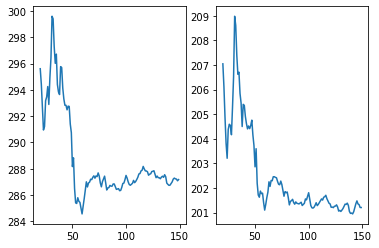

In [198]:
fig,ax = plt.subplots(1,2)
rmse_seek_p = [p[0].values for p in seek_p]
rmae_seek_p = [p[1].values for p in seek_p]

ax[0].plot(test_p,rmse_seek_p,  )
ax[1].plot(test_p,rmae_seek_p, )

print('profondeur Ideale RMSE : ',test_p[np.argmin(rmse_seek_p)],seek_p[np.argmin(rmse_seek_p)][0].values,'MAE',seek_p[np.argmin(rmse_seek_p)][1].values )
print('profondeur Ideale MAE : ',test_p[np.argmin(rmae_seek_p)],seek_p[np.argmin(rmae_seek_p)][1].values,'RMSE',seek_p[np.argmin(rmae_seek_p)][0].values )





In [57]:
mae_turb1 = smae_1/l1
rmse_turb1 = np.sqrt(srmse_1/l1)

print('rmse_turb1 :', rmse_turb1)
print('mae_turb1 :', mae_turb1)



rmse_turb1 : 288.83572152919743
mae_turb1 : 202.78972744189713


In [636]:
# Prédiction toutes les 24 heures sans disposer des prévisions des 12 dernières heures moyenné avec N1
smae_N1 = 0
srmse_N1 = 0
l1 = 0
y_pred1_N1 = []
k = 36
p = 95 # on prend 95 jours d'historique

for i in range(0,181):
    x_train1_i = np.array(Turb1[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][7276-p*24+i*24:7276+i*24-12])
    x_test1_i = np.array(Turb1[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][7276+i*24:7276+i*24+36])
    y_train1_i = np.array(Turb1[['ActivePower']][7276-p*24+i*24:7276+i*24-12])
    y_test1_i = np.array(Turb1[['ActivePower']][7276+i*24:7276+i*24+36])
    reg1_i = LinearRegression().fit(x_train1_i, y_train1_i)
    y_pred1_i = reg1_i.predict(x_test1_i)
    smae_N1 += np.sum(np.absolute(y_test1_i - y_pred1_i))
    srmse_N1 += np.sum((y_test1_i - y_pred1_i)**2)
    # ravel, tu moyennes avec Turb['N1'][7276+i*24:7276+i*24+36] sur les bons indices
    l1 += len(y_test1_i)
    y_pred1.append(y_pred1_i)

181

In [663]:
mae_turb1 = smae_N1/l1
rmse_turb1 = np.sqrt(srmse_N1/l1)

print('mae_turb1 :', mae_turb1)
print('rmse_turb1 :', rmse_turb1)

[array([[ 530.224994  ],
        [ 567.60968041],
        [ 686.91024839],
        [ 870.07579826],
        [ 775.93543488],
        [ 898.02204676],
        [ 877.99721362],
        [ 817.75137143],
        [ 852.24403823],
        [ 861.80237251],
        [ 981.88194454],
        [ 905.05980648],
        [ 953.53393589],
        [ 945.21419788],
        [ 914.14588646],
        [ 993.25449545],
        [1015.8523478 ],
        [ 903.03261073],
        [ 810.75356402],
        [ 903.21331059],
        [1003.79022253],
        [1101.79258847],
        [1116.7050071 ],
        [1096.67736282],
        [ 898.70253968],
        [ 958.3319421 ],
        [ 972.20666712],
        [ 984.45067273],
        [ 988.56049589],
        [1052.79752766],
        [1083.58265997],
        [1019.72192228],
        [ 876.52347059],
        [ 780.19473974],
        [ 787.29882592],
        [ 824.13501378]]),
 array([[ 899.9075952 ],
        [ 959.39218751],
        [ 973.05328399],
        [ 985.0878038 ]

## Turbine 2

In [58]:
# Prédiction toutes les 24 heures sans disposer des prévisions des 12 dernières heures
smae_2 = 0
srmse_2 = 0
l2 = 0
y_pred2 = []
k = 36
p = 101 # profondeur d'historique en jours

for i in range(0,187):
    x_train2_i = np.array(Turb2[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][7221-p*24+i*24:7221+i*24-12])
    x_test2_i = np.array(Turb2[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][7221+i*24:7221+i*24+36])
    y_train2_i = np.array(Turb2[['ActivePower']][7221-p*24+i*24:7221+i*24-12])
    y_test2_i = np.array(Turb2[['ActivePower']][7221+i*24:7221+i*24+36])
    reg2_i = LinearRegression().fit(x_train2_i, y_train2_i)
    y_pred2_i = reg2_i.predict(x_test2_i)
    smae_2 += np.sum(np.absolute(y_test2_i - y_pred2_i))
    srmse_2 += np.sum((y_test2_i - y_pred2_i)**2)
    l2 += len(y_test2_i)
    y_pred2.append(y_pred2_i)

In [59]:
# 36 indices glissants
mae_turb2 = smae_2/l2
rmse_turb2 = np.sqrt(srmse_2/l2)

print('mae_turb2 :', mae_turb2)
print('rmse_turb2 :', rmse_turb2)

mae_turb2 : 293.72387546356583
rmse_turb2 : 425.34058688958226


## Turbine 3

In [113]:
# Prédiction toutes les 24 heures sans disposer des prévisions des 12 dernières heures
smae_3 = 0
srmse_3 = 0
l3 = 0
y_pred3 = []
k = 36
p = 121 # profondeur d'historique en jours

for i in range(0,191):
    x_train3_i = np.array(Turb3[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][6570-p*24+i*24:6570+i*24-12])
    x_test3_i = np.array(Turb3[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][6570+i*24:6570+i*24+36])
    y_train3_i = np.array(Turb3[['ActivePower']][6570-p*24+i*24:6570+i*24-12])
    y_test3_i = np.array(Turb3[['ActivePower']][6570+i*24:6570+i*24+36])
    reg3_i = LinearRegression().fit(x_train3_i, y_train3_i)
    y_pred3_i = reg3_i.predict(x_test3_i)
    smae_3 += np.sum(np.absolute(y_test3_i - y_pred3_i))
    srmse_3 += np.sum((y_test3_i - y_pred3_i)**2)
    l3 += len(y_test3_i)
    y_pred3.append(y_pred3_i)

In [114]:
# 36 indices glissants
mae_turb3 = smae_3/l3
rmse_turb3 = np.sqrt(srmse_3/l3)

print('mae_turb3 :', mae_turb3)
print('rmse_turb3 :', rmse_turb3)

mae_turb3 : 148.6165990079865
rmse_turb3 : 208.88770424431706


## Turbine 4

In [91]:
# Prédiction toutes les 24 heures sans disposer des prévisions des 12 dernières heures
smae_4 = 0
srmse_4 = 0
l4 = 0
y_pred4 = []
k = 36
p = 110 # profondeur d'historique en jours

for i in range(0,176):
    x_train4_i = np.array(Turb4[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][6379-p*24+i*24:6379+i*24-12])
    x_test4_i = np.array(Turb4[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][6379+i*24:6379+i*24+36])
    y_train4_i = np.array(Turb4[['ActivePower']][6379-p*24+i*24:6379+i*24-12])
    y_test4_i = np.array(Turb4[['ActivePower']][6379+i*24:6379+i*24+36])
    reg4_i = LinearRegression().fit(x_train4_i, y_train4_i)
    y_pred4_i = reg4_i.predict(x_test4_i)
    smae_4 += np.sum(np.absolute(y_test4_i - y_pred4_i))
    srmse_4 += np.sum((y_test4_i - y_pred4_i)**2)
    l4 += len(y_test4_i)
    y_pred4.append(y_pred4_i)

In [92]:
# 36 indices glissants
mae_turb4 = smae_4/l4
rmse_turb4 = np.sqrt(srmse_4/l4)

print('mae_turb4 :', mae_turb4)
print('rmse_turb4 :', rmse_turb4)

mae_turb4 : 136.77773164062253
rmse_turb4 : 194.22555285491978


## Turbine 5

In [ ]:
# Prédiction toutes les 24 heures sans disposer des prévisions des 12 dernières heures
smae_5 = 0
srmse_5 = 0
l5 = 0
y_pred5 = []
k = 36
p = 110 # profondeur d'historique en jours

for i in range(0,176):
    x_train5_i = np.array(Turb5[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][7290-p*24+i*24:7290+i*24-12])
    x_test5_i = np.array(Turb5[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][7290+i*24:7290+i*24+36])
    y_train5_i = np.array(Turb5[['ActivePower']][7290-p*24+i*24:7290+i*24-12])
    y_test5_i = np.array(Turb5[['ActivePower']][7290+i*24:7290+i*24+36])
    reg5_i = LinearRegression().fit(x_train5_i, y_train5_i)
    y_pred5_i = reg5_i.predict(x_test5_i)
    smae_5 += np.sum(np.absolute(y_test5_i - y_pred5_i))
    srmse_5 += np.sum((y_test5_i - y_pred5_i)**2)
    l5 += len(y_test5_i)
    y_pred5.append(y_pred5_i)

In [ ]:
# 36 indices glissants
mae_turb4 = smae_4/l4
rmse_turb4 = np.sqrt(srmse_4/l4)

print('mae_turb4 :', mae_turb4)
print('rmse_turb4 :', rmse_turb4)

In [ ]:
df.drop(df.index[3:7],0,inplace=True)

In [117]:
(13118 - 7290 - 36)/24

241.33333333333334

In [115]:
Turb5

,DateTime,ActivePower,ProductionForecast_D,ProductionForecast_M,Year,Month,Day,Hour,N1,N2,D<M,D*M,D-M2,D2-M,Lreg5,mean5
0,2020-01-30 17:00:00,2866.364556,3112.223161,2775.0,2020,1,30,17,2887.407720,2883.138918,False,8.636419e+06,-7.697513e+06,9.683158e+06,0.000000,1443.703860
1,2020-01-30 18:00:00,3299.760818,3074.894251,3000.0,2020,1,30,18,3024.964750,3024.759838,False,9.224683e+06,-8.996925e+06,9.451975e+06,0.000000,1512.482375
2,2020-01-30 19:00:00,2960.236933,3115.750866,3022.5,2020,1,30,19,3053.583622,3053.269325,False,9.417357e+06,-9.132390e+06,9.704881e+06,0.000000,1526.791811
3,2020-01-30 20:00:00,2354.139261,3012.623302,3022.5,2020,1,30,20,3019.207767,3019.204175,True,9.105654e+06,-9.132494e+06,9.072877e+06,0.000000,1509.603884
4,2020-01-30 21:00:00,2047.085904,3003.807589,3045.0,2020,1,30,21,3031.269196,3031.206811,True,9.146594e+06,-9.269021e+06,9.019815e+06,0.000000,1515.634598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13113,2021-12-31 20:00:00,346.106680,718.294941,712.5,2021,12,31,20,714.431647,714.426434,False,5.117851e+05,-5.069380e+05,5.152351e+05,928.678964,821.555306
13114,2021-12-31 21:00:00,354.206817,676.444400,712.5,2021,12,31,21,700.481467,700.272837,True,4.819666e+05,-5.069798e+05,4.568645e+05,949.391701,824.936584
13115,2021-12-31 22:00:00,845.032503,1018.052085,637.5,2021,12,31,22,764.350695,745.149576,False,6.490082e+05,-4.053882e+05,1.035793e+06,969.862154,867.106425
13116,2021-12-31 23:00:00,531.395565,1086.595598,562.5,2021,12,31,23,737.198533,700.547625,False,6.112100e+05,-3.153197e+05,1.180127e+06,937.376529,837.287531


In [533]:
rmse = mean_squared_error(y_test2, y_pred2,squared=False)
rmse

426.2563306480059

In [534]:
mae = mean_absolute_error(y_test2, y_pred2)
mae

304.0228052632646

## Moyenne (2M+D)/3

In [535]:
N1_pred2 = Turb2['N1'][7221:].values

In [536]:
rmse = mean_squared_error(y_test2, N1_pred2,squared=False)
rmse

428.70990931895165

In [537]:
mae = mean_absolute_error(y_test2, N1_pred2)
mae

286.4498924140471

## Moyenne N1 et régression linéaire

In [538]:
Turb2['Lreg2'] = 0

In [539]:
Turb2['Lreg2'][7221:] = y_pred2

/var/folders/cw/kx_3dyf974s_v921k9zgp8w80000gn/T/ipykernel_15240/572274458.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Turb2['Lreg2'][7221:] = y_pred2


In [540]:
Turb2['mean'] = (Turb2['Lreg2'] + Turb2['N1']) / 2

In [541]:
mean2 = Turb2['mean'][7221:].values

In [542]:
rmse = mean_squared_error(y_test2, mean2,squared=False)
rmse

423.2105816376948

In [543]:
mae = mean_absolute_error(y_test2, mean2)
mae

290.20626180576903

# Online

In [544]:
# Prédiction toutes les heures
smae_2 = 0
smrse_2 = 0
l2 = 0
y_pred2 = []
k = 36
d = 9000 # on prend 3 mois d'historique 

for i in range(d, 11678-k):
    x_train2_i = np.array(Turb2[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][i-d:i])
    x_test2_i = np.array(Turb2[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][i:i+k])
    y_train2_i = np.array(Turb2[['ActivePower']][i-d:i])
    y_test2_i = np.array(Turb2[['ActivePower']][i:i+k])
    reg2_i = LinearRegression().fit(x_train1_i, y_train1_i)
    y_pred2_i = reg2_i.predict(x_test2_i)
    smae_2 += np.sum(np.absolute(y_test2_i - y_pred2_i))
    smrse_2 += np.sum((y_test2_i - y_pred2_i)**2)
    l2 += len(y_test2_i)
    y_pred2.append(y_pred2_i)

In [545]:
# 2 jours glissants
mae_turb2 = smae_2/l2
mrse_turb2 = np.sqrt(smrse_2/l2)

print('MAE_turb2 :', mae_turb2)
print('MRSE_turb2 :', mrse_turb2)

MAE_turb2 : 268.5711330083966
MRSE_turb2 : 387.2110247350719


In [637]:
(11762 - 7221 - 36)/24

187.70833333333334

In [591]:
8990-24

8966

In [658]:
# Prédiction toutes les 24 heures sans disposer des prévisions des 12 dernières heures
smae_2 = 0
smrse_2 = 0
l2 = 0
y_pred2 = []
k = 36
p = 101 # on prend 95 jours de profondeur d'historique

for i in range(0,187):
    x_train2_i = np.array(Turb2[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][7221-p*24+i*24:7221+i*24-12])
    x_test2_i = np.array(Turb2[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][7221+i*24:7221+i*24+36])
    y_train2_i = np.array(Turb2[['ActivePower']][7221-p*24+i*24:7221+i*24-12])
    y_test2_i = np.array(Turb2[['ActivePower']][7221+i*24:7221+i*24+36])
    reg2_i = LinearRegression().fit(x_train2_i, y_train2_i)
    y_pred2_i = reg2_i.predict(x_test2_i)
    smae_2 += np.sum(np.absolute(y_test2_i - y_pred2_i))
    smrse_2 += np.sum((y_test2_i - y_pred2_i)**2)
    l2 += len(y_test2_i)
    y_pred2.append(y_pred2_i)

In [662]:
113*115

12995

In [659]:
# 2 jours glissants
mae_turb2 = smae_2/l2
mrse_turb2 = np.sqrt(smrse_2/l2)

print('MAE_turb2 :', mae_turb2)
print('MRSE_turb2 :', mrse_turb2)

MAE_turb2 : 293.72387546356583
MRSE_turb2 : 425.34058688958226


# Brouillon / ne pas regarder en relecture
## XBG Optunisé turbine 1

In [388]:
X_train = Turb1[['N2','D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][0:7276].values

In [389]:
y_train = Turb1['ActivePower'][0:7276].values

In [390]:
X_test = Turb1[['N2','D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][7276:].values

In [391]:
y_test = Turb1['ActivePower'][7276:].values

In [392]:
data = X_train
target = y_train


def objective(trial,data=data,target=target):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    param = {
        'tree_method':'approx',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 4000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [393]:
# Study Turb1
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-05-15 17:08:53,244] A new study created in memory with name: no-name-0c771a20-6fb6-4dcf-8c8f-1f0c58bb00ed
[I 2022-05-15 17:08:54,986] Trial 0 finished with value: 296.790642272642 and parameters: {'lambda': 2.150524469485612, 'alpha': 3.2474150176457197, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 167}. Best is trial 0 with value: 296.790642272642.
[I 2022-05-15 17:08:56,653] Trial 1 finished with value: 296.9715272548736 and parameters: {'lambda': 0.1424405673384502, 'alpha': 0.001412342319570873, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 113}. Best is trial 0 with value: 296.790642272642.
[I 2022-05-15 17:08:58,631] Trial 2 finished with value: 297.4514757418688 and parameters: {'lambda': 0.3749130968603129, 'alpha': 0.009270027727569, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 9,

[I 2022-05-15 17:09:28,358] Trial 24 finished with value: 296.6568675413483 and parameters: {'lambda': 0.013928647732815314, 'alpha': 0.2987295354053405, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 136}. Best is trial 18 with value: 296.50140015263594.
[I 2022-05-15 17:09:29,542] Trial 25 finished with value: 297.5719912700935 and parameters: {'lambda': 0.15664079710967216, 'alpha': 0.05282629050525632, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.012, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 93}. Best is trial 18 with value: 296.50140015263594.
[I 2022-05-15 17:09:31,832] Trial 26 finished with value: 301.1661688986838 and parameters: {'lambda': 0.001920011287051784, 'alpha': 0.2797645862571478, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 40}. Best is trial 18 with value: 296.50140015263594.
[I 

[I 2022-05-15 17:10:00,085] Trial 48 finished with value: 297.20592112454733 and parameters: {'lambda': 0.0014126066927198533, 'alpha': 0.009576073452299891, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 103}. Best is trial 43 with value: 296.35086986612146.
[I 2022-05-15 17:10:00,821] Trial 49 finished with value: 296.6731093308808 and parameters: {'lambda': 0.012072467684368201, 'alpha': 0.0012479790652939482, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 188}. Best is trial 43 with value: 296.35086986612146.


Number of finished trials: 50
Best trial: {'lambda': 0.004338005956788233, 'alpha': 0.005853390818263026, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 154}


In [ ]:
{'lambda': 4.831389060251782, 'alpha': 5.692940678292804, 'colsample_bytree': 1.0, 
           'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 17, 'random_state': 24, 
           'min_child_weight': 205}

In [394]:
params1 =  {'lambda': 0.004338005956788233, 'alpha': 0.005853390818263026, 'colsample_bytree': 0.8,
            'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 11, 'random_state': 24, 
            'min_child_weight': 154}
Lreg1_optuna1 = XGBRegressor(**params1)

In [395]:
Lreg_opt = Lreg1_optuna1.fit(X_train, y_train)

In [396]:
y_pred_opt = Lreg_opt.predict(X_test)

In [397]:
rmse = mean_squared_error(y_test, y_pred_opt,squared=False)
rmse

338.95505154907477

In [398]:
mae = mean_absolute_error(y_test, y_pred_opt)
mae

228.63442512666205

In [277]:
Turb1['Lreg_opt'] = 0

In [278]:
Turb1['Lreg_opt'][7276:] = y_pred_opt

/var/folders/cw/kx_3dyf974s_v921k9zgp8w80000gn/T/ipykernel_15240/1942005391.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Turb1['Lreg_opt'][7276:] = y_pred_opt


In [279]:
Turb1['mean2'] = Turb1['Lreg_opt'] 

In [280]:
mean2 = Turb1['mean2'][7276:].values

In [281]:
rmse = mean_squared_error(y_test, mean2,squared=False)
rmse

294.89369357920197

In [282]:
mae = mean_absolute_error(y_test1, mean2)
mae

207.13124439321572

In [192]:
mean2 == y_pred_opt

array([False, False, False, ..., False, False, False])